In [1]:
import librosa
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from tensorflow.contrib import keras
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import regularizers
from tensorflow.contrib.keras import metrics
from sklearn import preprocessing
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

/Users/Gundeep/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Preprocessing functions

In [2]:
le = preprocessing.LabelEncoder()
encoder_is_fit = False
exclude_folders_default = ['hawkers','last_sample','parkhin_na_pahunch_jatt_di','thoda_ja_lamba_phrase','ah_drakht_boht_sohna_lag_reha',
                  'balli_ik_kam_kar','kuch_nava_try_karo','mausam_vadia_ajj']
exclude_folders_default = ['hawkers','thoda_ja_lamba_phrase','ah_drakht_boht_sohna_lag_reha','kuch_nava_try_karo','mausam_vadia_ajj']
def normalize(samples):
    return (samples-np.mean(samples))/np.std(samples)

def extract_feature(file_name, printLog = False):
    X, sample_rate = librosa.load(file_name)
    X = normalize(X)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T,axis=0)
#     delta = librosa.feature.delta
    chroma = np.sum(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0) # stft used
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0) # stft used
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
      sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
#     ext_features = np.hstack([mfccs,chroma,mel,tonnetz])
    if printLog:
      print('sample rate = %s'%sample_rate)
      print('mfccs shape = %s'%mfccs.shape)
      print('chroma shape = %s'%chroma.shape)
#       print('mel shape = %s'%mel.shape)
#       print('contrast shape = %s'%contrast.shape)
      print('tonnetz shape = %s'%tonnetz.shape)
    return ext_features

def parse_audio_files(root_path, log=False,exclude_folders=exclude_folders_default):
#     fts, labels = np.empty((0,193), dtype=np.float32), np.empty((0))
    fts, labels = np.empty((0,173), dtype=np.float32), np.empty((0))
    folders = (os.path.join(root_path,f) for f in os.listdir(root_path) 
                  if (os.path.isdir(os.path.join(root_path,f)) and not f.startswith('.')
                     and f not in exclude_folders))
    for fldr in folders:
        wave_files = (os.path.join(fldr, f) for f in os.listdir(fldr) if (f.endswith('.wav') 
            and os.path.isfile(os.path.join(fldr, f))))
        if log:
          print('\n\nnavigating in the folder = %s'%str(fldr))
        for f in wave_files:
              if log:
                print(str(f))
              ext_features = extract_feature(f)
              fts = np.vstack([fts,ext_features])
              labels = np.append(labels, os.path.basename(fldr))
    return fts,labels

def one_hot_encode(labels, force_fit=False):
    global encoder_is_fit
    global encoded_labels
    if force_fit or not encoder_is_fit:
        encoded_labels = le.fit_transform(labels)
        encoder_is_fit = True
    else:
        encoded_labels = le.transform(labels)
    one_hot_encode = keras.utils.to_categorical(encoded_labels)
    return one_hot_encode

## Some testing functions

In [3]:
y, sr = librosa.load(librosa.util.example_audio_file())

In [4]:
ex = librosa.feature.mfcc(y=y[:sr], sr=sr)

In [5]:
ex.shape

(20, 44)

In [7]:
audio,sr = librosa.load('sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/1.wav')
mfcc = librosa.feature.mfcc(y=audio[:sr], sr=sr, n_mfcc=20)

In [8]:
mfcc.shape

(20, 44)

In [9]:
features1 = extract_feature('sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/1.wav', printLog=True)
features2 = extract_feature('sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/2.wav', printLog=True)
print(features1.shape)
print(features2.shape)
# print(np.vstack([features1.shape,features2.shape]))

sample rate = 22050
mfccs shape = 20
chroma shape = 12
tonnetz shape = 6
sample rate = 22050
mfccs shape = 20
chroma shape = 12
tonnetz shape = 6
(173,)
(173,)


In [10]:
def printFeatureDetails(wave_file_path):
    if os.path.exists(wave_file_path):
        x,y = librosa.load(wave_file_path)
        stft = np.abs(librosa.stft(x))
        chroma = librosa.feature.chroma_stft(S=stft, sr=y)
        print('x.shape = %s, y = %d'%(str(x.shape), y))
        print('stft.shape = %s'%str(stft.shape))
        print('chroma.shape = %s'%str(chroma.shape))
    else:
        print('file \'%s\' doesn\'t exist'%wave_file_path)

## Extract the features

In [23]:
#define paths
root_path_large = 'sounds/recorded/large'
root_path_small = 'sounds/recorded/small'

#extract features
train_x, train_y = parse_audio_files(root_path_large)
test_x, test_y = parse_audio_files(root_path_small)

print_data_shape()

train_x.shape = (79, 173)
train_y.shape = (79,)
test_x.shape = (11, 173)
test_y.shape = (11,)


## urban8k dataset

In [ ]:
exclude_folders_urban = ['air_conditioner','children_playing','engine_idling','siren','street_music']
#define paths
root_path_large_urban = 'sounds/urban_sounds/large'
root_path_small_urban = 'sounds/urban_sounds/small'

#extract features
train_x, train_y = parse_audio_files(root_path_large_urban, exclude_folders=exclude_folders_urban)
test_x, test_y = parse_audio_files(root_path_small_urban, exclude_folders=exclude_folders_urban)

print_data_shape()

In [24]:
def print_data_shape():
    print('train_x.shape = %s'%str(train_x.shape))
    print('train_y.shape = %s'%str(train_y.shape))
    print('test_x.shape = %s'%str(test_x.shape))
    print('test_y.shape = %s'%str(test_y.shape))

In [25]:
print_data_shape()

train_x.shape = (79, 173)
train_y.shape = (79,)
test_x.shape = (11, 173)
test_y.shape = (11,)


## Randomize and 1-hot before saving

In [26]:
# define randomize
np.random.seed(341136787)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

#randomize
train_x, train_y = randomize(train_x, train_y)
test_x, test_y = randomize(test_x, test_y)

#one hot encode the labels
train_y = one_hot_encode(train_y)
test_y = one_hot_encode(test_y)

## Save pickle

In [3]:
# dump to pickle
def pickle_the_examples(urban=False):
    if os.environ['HOME'] == '/Users/Gundeep':
        if not urban:
            pickle_filename = '/Users/Gundeep/Projects/Punjabi/punjabi_pickle.pickle'
        else:
            pickle_filename = '/Users/Gundeep/Projects/Punjabi/urban_pickle.pickle'
    else:
        if not urban:
            pickle_filename = '/home/paperspace/Documents/Projects/Punjabi/punjabi_pickle.pickle'
        else:
            pickle_filename = '/Users/Gundeep/Projects/Punjabi/urban_pickle.pickle'
    pickle_dump = {'train_x' : train_x,
                   'train_y' : train_y,
                   'test_x' : test_x,
                   'test_y' : test_y}
    import pickle
    try:
      with open(pickle_filename, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
      print('Unable to save data to', pickle_filename, ':', e)

In [ ]:
pickle_the_examples(True)

In [28]:
os.environ['HOME']

'/Users/Gundeep'

## Load pickle

In [29]:
# load from pickle
import pickle
pickle_filename = ''
if os.environ['HOME'] == '/Users/Gundeep':
    pickle_filename = '/Users/Gundeep/Projects/Punjabi/punjabi_pickle.pickle'
else:
    pickle_filename = '/home/paperspace/Documents/Projects/Punjabi/punjabi_pickle.pickle'
pickle_dump = {}
try:
  with open(pickle_filename, 'rb') as f:
    pickle_dump = pickle.load(f)
except Exception as e:
  print('Unable to load pickle', pickle_filename, ':', e)

In [30]:
# load the data into variables
train_x = pickle_dump['train_x']
train_y = pickle_dump['train_y']
test_x = pickle_dump['test_x']
test_y = pickle_dump['test_y']

# fucntion to print data shapes
def print_data_shape():
    print('train_x.shape = %s'%str(train_x.shape))
    print('train_y.shape = %s'%str(train_y.shape))
    print('test_x.shape = %s'%str(test_x.shape))
    print('test_y.shape = %s'%str(test_y.shape))

print_data_shape()

train_x.shape = (79, 173)
train_y.shape = (79, 5)
test_x.shape = (11, 173)
test_y.shape = (11, 5)


## Model Training

In [31]:
# imports
categorical_accuracy = metrics.categorical_accuracy
Sequential = models.Sequential
Dense = layers.Dense
Dropout = layers.Dropout

#numpy.random.seed(7)

# enable tensorflow logging
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [32]:
global training_epochs
global n_dim
global b_size
global n_classes
global n_hidden_units_one
global n_hidden_units_two
global sd
global learning_rate
def load_hp():
    #hyper paramters
    global training_epochs
    global n_dim
    global b_size
    global n_classes
    global n_hidden_units_one
    global n_hidden_units_two
    global sd
    global learning_rate
    training_epochs = 800
    n_dim = train_x.shape[1]
    b_size = 10
    n_classes = 5
    n_hidden_units_one = 128
    n_hidden_units_two = 32
    sd = 1 / np.sqrt(n_dim)
    learning_rate = 0.0005

In [33]:
def create_model():
    model = None
    model = Sequential()
    model.add(Dense(n_hidden_units_one, input_dim=n_dim, activation='relu', kernel_regularizer=regularizers.l2(0.002)))
    model.add(Dropout(0.15))
    model.add(Dense(n_hidden_units_two, activation='relu', kernel_regularizer=regularizers.l2(0.002)))
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [34]:
load_hp()
def train_model(model,train_x,train_y,split=0.3,epochs=training_epochs):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[categorical_accuracy])
    return model.fit(train_x, train_y, epochs=epochs, validation_split=split, batch_size=b_size)

In [35]:
def plot_history(plottable_history,plotevery=10):
    #  print(plottable_history.history.keys())
    #  "Accuracy"
    plt.plot(plottable_history.history['categorical_accuracy'][::plotevery])
    plt.plot(plottable_history.history['val_categorical_accuracy'][::plotevery])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(plottable_history.history['loss'][::plotevery])
    plt.plot(plottable_history.history['val_loss'][::plotevery])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Train a single model

Train on 143 samples, validate on 62 samples
Epoch 1/800
143/143 [==============================] - 0s - loss: 7.2895 - categorical_accuracy: 0.5664 - val_loss: 7.7971 - val_categorical_accuracy: 0.5323
Epoch 2/800
143/143 [==============================] - 0s - loss: 6.1008 - categorical_accuracy: 0.6364 - val_loss: 5.8853 - val_categorical_accuracy: 0.6452
Epoch 3/800
143/143 [==============================] - 0s - loss: 6.3231 - categorical_accuracy: 0.6154 - val_loss: 5.6289 - val_categorical_accuracy: 0.6613
Epoch 4/800
143/143 [==============================] - 0s - loss: 5.4616 - categorical_accuracy: 0.6713 - val_loss: 6.1263 - val_categorical_accuracy: 0.6290
Epoch 5/800
143/143 [==============================] - 0s - loss: 5.6310 - categorical_accuracy: 0.6573 - val_loss: 5.5948 - val_categorical_accuracy: 0.6613
Epoch 6/800
143/143 [==============================] - 0s - loss: 5.0930 - categorical_accuracy: 0.6923 - val_loss: 6.2765 - val_categorical_accuracy: 0.5968
Epoch 7

143/143 [==============================] - 0s - loss: 8.6314 - categorical_accuracy: 0.4685 - val_loss: 7.6097 - val_categorical_accuracy: 0.5323
Epoch 103/800
143/143 [==============================] - 0s - loss: 8.6311 - categorical_accuracy: 0.4685 - val_loss: 7.6094 - val_categorical_accuracy: 0.5323
Epoch 104/800
143/143 [==============================] - 0s - loss: 8.6308 - categorical_accuracy: 0.4685 - val_loss: 7.6091 - val_categorical_accuracy: 0.5323
Epoch 105/800
143/143 [==============================] - 0s - loss: 8.6305 - categorical_accuracy: 0.4685 - val_loss: 7.6088 - val_categorical_accuracy: 0.5323
Epoch 106/800
143/143 [==============================] - 0s - loss: 8.6302 - categorical_accuracy: 0.4685 - val_loss: 7.6085 - val_categorical_accuracy: 0.5323
Epoch 107/800
143/143 [==============================] - 0s - loss: 8.6300 - categorical_accuracy: 0.4685 - val_loss: 7.6083 - val_categorical_accuracy: 0.5323
Epoch 108/800
143/143 [==============================]

143/143 [==============================] - 0s - loss: 8.6058 - categorical_accuracy: 0.4685 - val_loss: 7.5842 - val_categorical_accuracy: 0.5323
Epoch 205/800
143/143 [==============================] - 0s - loss: 8.6056 - categorical_accuracy: 0.4685 - val_loss: 7.5839 - val_categorical_accuracy: 0.5323
Epoch 206/800
143/143 [==============================] - 0s - loss: 8.6054 - categorical_accuracy: 0.4685 - val_loss: 7.5837 - val_categorical_accuracy: 0.5323
Epoch 207/800
143/143 [==============================] - 0s - loss: 8.6052 - categorical_accuracy: 0.4685 - val_loss: 7.5835 - val_categorical_accuracy: 0.5323
Epoch 208/800
143/143 [==============================] - 0s - loss: 8.6050 - categorical_accuracy: 0.4685 - val_loss: 7.5833 - val_categorical_accuracy: 0.5323
Epoch 209/800
143/143 [==============================] - 0s - loss: 8.6047 - categorical_accuracy: 0.4685 - val_loss: 7.5831 - val_categorical_accuracy: 0.5323
Epoch 210/800
143/143 [==============================]

143/143 [==============================] - 0s - loss: 8.5851 - categorical_accuracy: 0.4685 - val_loss: 7.5635 - val_categorical_accuracy: 0.5323
Epoch 306/800
143/143 [==============================] - ETA: 0s - loss: 4.8745 - categorical_accuracy: 0.70 - 0s - loss: 8.5849 - categorical_accuracy: 0.4685 - val_loss: 7.5633 - val_categorical_accuracy: 0.5323
Epoch 307/800
143/143 [==============================] - 0s - loss: 8.5847 - categorical_accuracy: 0.4685 - val_loss: 7.5631 - val_categorical_accuracy: 0.5323
Epoch 308/800
143/143 [==============================] - 0s - loss: 8.5846 - categorical_accuracy: 0.4685 - val_loss: 7.5629 - val_categorical_accuracy: 0.5323
Epoch 309/800
143/143 [==============================] - 0s - loss: 8.5844 - categorical_accuracy: 0.4685 - val_loss: 7.5627 - val_categorical_accuracy: 0.5323
Epoch 310/800
143/143 [==============================] - 0s - loss: 8.5842 - categorical_accuracy: 0.4685 - val_loss: 7.5625 - val_categorical_accuracy: 0.5323


143/143 [==============================] - 0s - loss: 8.5671 - categorical_accuracy: 0.4685 - val_loss: 7.5455 - val_categorical_accuracy: 0.5323
Epoch 406/800
143/143 [==============================] - 0s - loss: 8.5669 - categorical_accuracy: 0.4685 - val_loss: 7.5453 - val_categorical_accuracy: 0.5323
Epoch 407/800
143/143 [==============================] - 0s - loss: 8.5668 - categorical_accuracy: 0.4685 - val_loss: 7.5451 - val_categorical_accuracy: 0.5323
Epoch 408/800
143/143 [==============================] - 0s - loss: 8.5666 - categorical_accuracy: 0.4685 - val_loss: 7.5450 - val_categorical_accuracy: 0.5323
Epoch 409/800
143/143 [==============================] - 0s - loss: 8.5664 - categorical_accuracy: 0.4685 - val_loss: 7.5448 - val_categorical_accuracy: 0.5323
Epoch 410/800
143/143 [==============================] - 0s - loss: 8.5663 - categorical_accuracy: 0.4685 - val_loss: 7.5446 - val_categorical_accuracy: 0.5323
Epoch 411/800
143/143 [==============================]

143/143 [==============================] - 0s - loss: 8.5511 - categorical_accuracy: 0.4685 - val_loss: 7.5295 - val_categorical_accuracy: 0.5323
Epoch 507/800
143/143 [==============================] - 0s - loss: 8.5509 - categorical_accuracy: 0.4685 - val_loss: 7.5293 - val_categorical_accuracy: 0.5323
Epoch 508/800
143/143 [==============================] - 0s - loss: 8.5508 - categorical_accuracy: 0.4685 - val_loss: 7.5292 - val_categorical_accuracy: 0.5323
Epoch 509/800
143/143 [==============================] - 0s - loss: 8.5507 - categorical_accuracy: 0.4685 - val_loss: 7.5290 - val_categorical_accuracy: 0.5323
Epoch 510/800
143/143 [==============================] - 0s - loss: 8.5505 - categorical_accuracy: 0.4685 - val_loss: 7.5289 - val_categorical_accuracy: 0.5323
Epoch 511/800
143/143 [==============================] - 0s - loss: 8.5504 - categorical_accuracy: 0.4685 - val_loss: 7.5287 - val_categorical_accuracy: 0.5323
Epoch 512/800
143/143 [==============================]

143/143 [==============================] - 0s - loss: 8.5380 - categorical_accuracy: 0.4685 - val_loss: 7.5164 - val_categorical_accuracy: 0.5323
Epoch 609/800
143/143 [==============================] - 0s - loss: 8.5379 - categorical_accuracy: 0.4685 - val_loss: 7.5163 - val_categorical_accuracy: 0.5323
Epoch 610/800
143/143 [==============================] - 0s - loss: 8.5378 - categorical_accuracy: 0.4685 - val_loss: 7.5161 - val_categorical_accuracy: 0.5323
Epoch 611/800
143/143 [==============================] - 0s - loss: 8.5376 - categorical_accuracy: 0.4685 - val_loss: 7.5160 - val_categorical_accuracy: 0.5323
Epoch 612/800
143/143 [==============================] - 0s - loss: 8.5375 - categorical_accuracy: 0.4685 - val_loss: 7.5159 - val_categorical_accuracy: 0.5323
Epoch 613/800
143/143 [==============================] - 0s - loss: 8.5374 - categorical_accuracy: 0.4685 - val_loss: 7.5158 - val_categorical_accuracy: 0.5323
Epoch 614/800
143/143 [==============================]

143/143 [==============================] - 0s - loss: 8.5287 - categorical_accuracy: 0.4685 - val_loss: 7.5071 - val_categorical_accuracy: 0.5323
Epoch 710/800
143/143 [==============================] - 0s - loss: 8.5286 - categorical_accuracy: 0.4685 - val_loss: 7.5070 - val_categorical_accuracy: 0.5323
Epoch 711/800
143/143 [==============================] - 0s - loss: 8.5285 - categorical_accuracy: 0.4685 - val_loss: 7.5069 - val_categorical_accuracy: 0.5323
Epoch 712/800
143/143 [==============================] - 0s - loss: 8.5285 - categorical_accuracy: 0.4685 - val_loss: 7.5069 - val_categorical_accuracy: 0.5323
Epoch 713/800
143/143 [==============================] - 0s - loss: 8.5284 - categorical_accuracy: 0.4685 - val_loss: 7.5068 - val_categorical_accuracy: 0.5323
Epoch 714/800
143/143 [==============================] - 0s - loss: 8.5283 - categorical_accuracy: 0.4685 - val_loss: 7.5067 - val_categorical_accuracy: 0.5323
Epoch 715/800
143/143 [==============================]

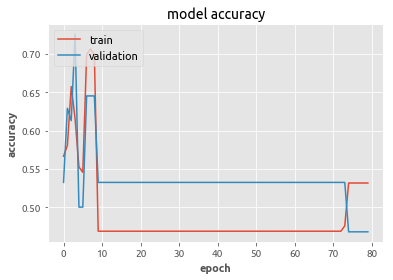

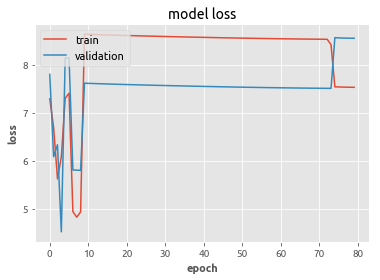

In [169]:
load_hp()
model = create_model()
plottable_history = train_model(model, train_x, train_y)
plot_history(plottable_history)

In [170]:
run_predictionpredictionpredictionpredictionprediction(update=True,log=True)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
correctly predicted = 10
incorrectly predicted = 15


## Train using different number of training examples

In [18]:
def multiple_num_examples():
    # train model for different number of training examples
    min_num = 69
    max_num = train_x.shape[0]
    fine_tuning = 60
    t_num = np.arange(min_num, max_num, fine_tuning)
    
    # load the model
    load_hp()
    model = create_model()
    
    # run model for different number of training examples
    loss_values = np.zeros(len(t_num))
    val_loss_values = np.zeros(len(t_num))
    acc_values = np.zeros(len(t_num))
    val_acc_values = np.zeros(len(t_num))
    
    for i,nm in enumerate(t_num):
        model_hist = train_model(model,train_x[:nm],train_y[:nm])
        acc_values[i] = model_hist.history['categorical_accuracy'][-1]
        val_acc_values[i] = model_hist.history['val_categorical_accuracy'][-1]
        loss_values[i] = model_hist.history['loss'][-1]
        val_loss_values[i] = model_hist.history['val_loss'][-1]
        
    return loss_values,val_loss_values,acc_values,val_acc_values
    

In [19]:
def plot_multiple_examples():
    # when training is complete, plot the graph of accuracy and loss against number training examples
    
    #  "Accuracy"
    plt.plot(t_num,acc_values)
    plt.plot(t_num,val_acc_values)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('n_examples')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(t_num,loss_values)
    plt.plot(t_num,val_loss_values)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('n_examples')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [20]:
loss_values,val_loss_values,acc_values,val_acc_values = multiple_num_examples()
plot_multiple_examples(loss_values,val_loss_values,acc_values,val_acc_values)

Train on 48 samples, validate on 21 samples
Epoch 1/800
48/48 [==============================] - 0s - loss: 8.5280 - categorical_accuracy: 0.4792 - val_loss: 5.7090 - val_categorical_accuracy: 0.6667
Epoch 2/800
48/48 [==============================] - 0s - loss: 5.7001 - categorical_accuracy: 0.6667 - val_loss: 5.6858 - val_categorical_accuracy: 0.6667
Epoch 3/800
48/48 [==============================] - 0s - loss: 4.4760 - categorical_accuracy: 0.7292 - val_loss: 4.9034 - val_categorical_accuracy: 0.7143
Epoch 4/800
48/48 [==============================] - 0s - loss: 4.6423 - categorical_accuracy: 0.7292 - val_loss: 5.0526 - val_categorical_accuracy: 0.6190
Epoch 5/800
48/48 [==============================] - 0s - loss: 5.6484 - categorical_accuracy: 0.6667 - val_loss: 7.1680 - val_categorical_accuracy: 0.5714
Epoch 6/800
48/48 [==============================] - 0s - loss: 5.3032 - categorical_accuracy: 0.6875 - val_loss: 7.1573 - val_categorical_accuracy: 0.5714
Epoch 7/800
48/48 [=

48/48 [==============================] - 0s - loss: 3.8372 - categorical_accuracy: 0.7708 - val_loss: 3.9802 - val_categorical_accuracy: 0.7619
Epoch 105/800
48/48 [==============================] - 0s - loss: 4.1709 - categorical_accuracy: 0.7500 - val_loss: 3.9800 - val_categorical_accuracy: 0.7619
Epoch 106/800
48/48 [==============================] - 0s - loss: 4.5047 - categorical_accuracy: 0.7292 - val_loss: 3.9798 - val_categorical_accuracy: 0.7619
Epoch 107/800
48/48 [==============================] - 0s - loss: 3.8365 - categorical_accuracy: 0.7708 - val_loss: 3.9795 - val_categorical_accuracy: 0.7619
Epoch 108/800
48/48 [==============================] - 0s - loss: 4.1703 - categorical_accuracy: 0.7500 - val_loss: 3.9793 - val_categorical_accuracy: 0.7619
Epoch 109/800
48/48 [==============================] - 0s - loss: 3.8361 - categorical_accuracy: 0.7708 - val_loss: 3.9791 - val_categorical_accuracy: 0.7619
Epoch 110/800
48/48 [==============================] - 0s - loss: 

48/48 [==============================] - 0s - loss: 4.8313 - categorical_accuracy: 0.7083 - val_loss: 7.7892 - val_categorical_accuracy: 0.5238
Epoch 207/800
48/48 [==============================] - 0s - loss: 4.8312 - categorical_accuracy: 0.7083 - val_loss: 7.7890 - val_categorical_accuracy: 0.5238
Epoch 208/800
48/48 [==============================] - 0s - loss: 5.4989 - categorical_accuracy: 0.6667 - val_loss: 7.7889 - val_categorical_accuracy: 0.5238
Epoch 209/800
48/48 [==============================] - 0s - loss: 4.1629 - categorical_accuracy: 0.7500 - val_loss: 7.7887 - val_categorical_accuracy: 0.5238
Epoch 210/800
48/48 [==============================] - 0s - loss: 4.1535 - categorical_accuracy: 0.7292 - val_loss: 7.0255 - val_categorical_accuracy: 0.5714
Epoch 211/800
48/48 [==============================] - 0s - loss: 3.1613 - categorical_accuracy: 0.8125 - val_loss: 6.2627 - val_categorical_accuracy: 0.6190
Epoch 212/800
48/48 [==============================] - 0s - loss: 

48/48 [==============================] - 0s - loss: 2.4843 - categorical_accuracy: 0.8542 - val_loss: 4.3961 - val_categorical_accuracy: 0.7143
Epoch 309/800
48/48 [==============================] - 0s - loss: 2.8181 - categorical_accuracy: 0.8333 - val_loss: 4.3982 - val_categorical_accuracy: 0.7143
Epoch 310/800
48/48 [==============================] - 0s - loss: 1.8161 - categorical_accuracy: 0.8958 - val_loss: 4.4004 - val_categorical_accuracy: 0.7143
Epoch 311/800
48/48 [==============================] - 0s - loss: 2.1500 - categorical_accuracy: 0.8750 - val_loss: 4.4027 - val_categorical_accuracy: 0.7143
Epoch 312/800
48/48 [==============================] - 0s - loss: 2.1499 - categorical_accuracy: 0.8750 - val_loss: 4.4047 - val_categorical_accuracy: 0.7143
Epoch 313/800
48/48 [==============================] - 0s - loss: 2.1498 - categorical_accuracy: 0.8750 - val_loss: 4.4069 - val_categorical_accuracy: 0.7143
Epoch 314/800
48/48 [==============================] - 0s - loss: 

48/48 [==============================] - 0s - loss: 1.4899 - categorical_accuracy: 0.9167 - val_loss: 4.7341 - val_categorical_accuracy: 0.7143
Epoch 411/800
48/48 [==============================] - 0s - loss: 1.8238 - categorical_accuracy: 0.8958 - val_loss: 4.7340 - val_categorical_accuracy: 0.7143
Epoch 412/800
48/48 [==============================] - 0s - loss: 1.8237 - categorical_accuracy: 0.8958 - val_loss: 4.7339 - val_categorical_accuracy: 0.7143
Epoch 413/800
48/48 [==============================] - 0s - loss: 2.8255 - categorical_accuracy: 0.8333 - val_loss: 4.7338 - val_categorical_accuracy: 0.7143
Epoch 414/800
48/48 [==============================] - 0s - loss: 2.1575 - categorical_accuracy: 0.8750 - val_loss: 4.7337 - val_categorical_accuracy: 0.7143
Epoch 415/800
48/48 [==============================] - 0s - loss: 1.1555 - categorical_accuracy: 0.9375 - val_loss: 4.7336 - val_categorical_accuracy: 0.7143
Epoch 416/800
48/48 [==============================] - 0s - loss: 

48/48 [==============================] - 0s - loss: 1.5018 - categorical_accuracy: 0.9167 - val_loss: 1.6790 - val_categorical_accuracy: 0.9048
Epoch 513/800
48/48 [==============================] - 0s - loss: 1.1542 - categorical_accuracy: 0.9375 - val_loss: 1.6789 - val_categorical_accuracy: 0.9048
Epoch 514/800
48/48 [==============================] - 0s - loss: 1.4881 - categorical_accuracy: 0.9167 - val_loss: 1.6789 - val_categorical_accuracy: 0.9048
Epoch 515/800
48/48 [==============================] - 0s - loss: 1.1541 - categorical_accuracy: 0.9375 - val_loss: 1.6789 - val_categorical_accuracy: 0.9048
Epoch 516/800
48/48 [==============================] - 0s - loss: 1.1541 - categorical_accuracy: 0.9375 - val_loss: 1.6788 - val_categorical_accuracy: 0.9048
Epoch 517/800
48/48 [==============================] - 0s - loss: 1.1540 - categorical_accuracy: 0.9375 - val_loss: 1.6787 - val_categorical_accuracy: 0.9048
Epoch 518/800
48/48 [==============================] - 0s - loss: 

48/48 [==============================] - 0s - loss: 1.1517 - categorical_accuracy: 0.9375 - val_loss: 1.6765 - val_categorical_accuracy: 0.9048
Epoch 615/800
48/48 [==============================] - 0s - loss: 1.1517 - categorical_accuracy: 0.9375 - val_loss: 1.6764 - val_categorical_accuracy: 0.9048
Epoch 616/800
48/48 [==============================] - ETA: 0s - loss: 0.1497 - categorical_accuracy: 1.00 - 0s - loss: 1.4855 - categorical_accuracy: 0.9167 - val_loss: 1.6763 - val_categorical_accuracy: 0.9048
Epoch 617/800
48/48 [==============================] - 0s - loss: 1.1515 - categorical_accuracy: 0.9375 - val_loss: 1.6763 - val_categorical_accuracy: 0.9048
Epoch 618/800
48/48 [==============================] - 0s - loss: 0.8175 - categorical_accuracy: 0.9583 - val_loss: 1.6762 - val_categorical_accuracy: 0.9048
Epoch 619/800
48/48 [==============================] - 0s - loss: 1.1514 - categorical_accuracy: 0.9375 - val_loss: 1.6761 - val_categorical_accuracy: 0.9048
Epoch 620/80

48/48 [==============================] - 0s - loss: 3.1496 - categorical_accuracy: 0.8125 - val_loss: 7.7773 - val_categorical_accuracy: 0.5238
Epoch 717/800
48/48 [==============================] - 0s - loss: 2.7431 - categorical_accuracy: 0.8333 - val_loss: 3.9615 - val_categorical_accuracy: 0.7619
Epoch 718/800
48/48 [==============================] - 0s - loss: 1.1472 - categorical_accuracy: 0.9375 - val_loss: 2.4361 - val_categorical_accuracy: 0.8571
Epoch 719/800
48/48 [==============================] - 0s - loss: 0.8144 - categorical_accuracy: 0.9583 - val_loss: 0.9104 - val_categorical_accuracy: 0.9524
Epoch 720/800
48/48 [==============================] - 0s - loss: 0.4812 - categorical_accuracy: 0.9792 - val_loss: 0.9110 - val_categorical_accuracy: 0.9524
Epoch 721/800
48/48 [==============================] - 0s - loss: 1.4836 - categorical_accuracy: 0.9167 - val_loss: 1.6746 - val_categorical_accuracy: 0.9048
Epoch 722/800
48/48 [==============================] - 0s - loss: 

90/90 [==============================] - 0s - loss: 1.8528 - categorical_accuracy: 0.8889 - val_loss: 2.1266 - val_categorical_accuracy: 0.8718
Epoch 19/800
90/90 [==============================] - 0s - loss: 1.2509 - categorical_accuracy: 0.9222 - val_loss: 2.5377 - val_categorical_accuracy: 0.8462
Epoch 20/800
90/90 [==============================] - 0s - loss: 1.1402 - categorical_accuracy: 0.9333 - val_loss: 2.9488 - val_categorical_accuracy: 0.8205
Epoch 21/800
90/90 [==============================] - 0s - loss: 1.4964 - categorical_accuracy: 0.9111 - val_loss: 2.9486 - val_categorical_accuracy: 0.8205
Epoch 22/800
90/90 [==============================] - 0s - loss: 1.6743 - categorical_accuracy: 0.9000 - val_loss: 2.9484 - val_categorical_accuracy: 0.8205
Epoch 23/800
90/90 [==============================] - 0s - loss: 1.6741 - categorical_accuracy: 0.9000 - val_loss: 2.9482 - val_categorical_accuracy: 0.8205
Epoch 24/800
90/90 [==============================] - 0s - loss: 1.4958

90/90 [==============================] - 0s - loss: 1.3184 - categorical_accuracy: 0.9222 - val_loss: 2.1267 - val_categorical_accuracy: 0.8718
Epoch 122/800
90/90 [==============================] - 0s - loss: 1.3183 - categorical_accuracy: 0.9222 - val_loss: 2.1266 - val_categorical_accuracy: 0.8718
Epoch 123/800
90/90 [==============================] - 0s - loss: 1.4963 - categorical_accuracy: 0.9111 - val_loss: 2.1266 - val_categorical_accuracy: 0.8718
Epoch 124/800
90/90 [==============================] - 0s - loss: 1.4963 - categorical_accuracy: 0.9111 - val_loss: 2.1265 - val_categorical_accuracy: 0.8718
Epoch 125/800
90/90 [==============================] - 0s - loss: 1.3181 - categorical_accuracy: 0.9222 - val_loss: 2.1264 - val_categorical_accuracy: 0.8718
Epoch 126/800
90/90 [==============================] - 0s - loss: 1.4962 - categorical_accuracy: 0.9111 - val_loss: 2.1264 - val_categorical_accuracy: 0.8718
Epoch 127/800
90/90 [==============================] - 0s - loss: 

90/90 [==============================] - 0s - loss: 7.2031 - categorical_accuracy: 0.5556 - val_loss: 6.6555 - val_categorical_accuracy: 0.5897
Epoch 224/800
90/90 [==============================] - 0s - loss: 8.2724 - categorical_accuracy: 0.4889 - val_loss: 6.6559 - val_categorical_accuracy: 0.5897
Epoch 225/800
90/90 [==============================] - 0s - loss: 8.8070 - categorical_accuracy: 0.4556 - val_loss: 7.4780 - val_categorical_accuracy: 0.5385
Epoch 226/800
90/90 [==============================] - 0s - loss: 8.6289 - categorical_accuracy: 0.4667 - val_loss: 7.4780 - val_categorical_accuracy: 0.5385
Epoch 227/800
90/90 [==============================] - 0s - loss: 8.6288 - categorical_accuracy: 0.4667 - val_loss: 7.4779 - val_categorical_accuracy: 0.5385
Epoch 228/800
90/90 [==============================] - 0s - loss: 9.0920 - categorical_accuracy: 0.4333 - val_loss: 6.6555 - val_categorical_accuracy: 0.5897
Epoch 229/800
90/90 [==============================] - 0s - loss: 

90/90 [==============================] - 0s - loss: 2.5823 - categorical_accuracy: 0.8444 - val_loss: 2.9663 - val_categorical_accuracy: 0.8205
Epoch 326/800
90/90 [==============================] - 0s - loss: 3.1174 - categorical_accuracy: 0.8111 - val_loss: 2.9666 - val_categorical_accuracy: 0.8205
Epoch 327/800
90/90 [==============================] - 0s - loss: 2.6738 - categorical_accuracy: 0.8333 - val_loss: 2.9665 - val_categorical_accuracy: 0.8205
Epoch 328/800
90/90 [==============================] - 0s - loss: 2.4047 - categorical_accuracy: 0.8556 - val_loss: 2.9666 - val_categorical_accuracy: 0.8205
Epoch 329/800
90/90 [==============================] - 0s - loss: 1.8706 - categorical_accuracy: 0.8889 - val_loss: 2.9667 - val_categorical_accuracy: 0.8205
Epoch 330/800
90/90 [==============================] - 0s - loss: 1.6925 - categorical_accuracy: 0.9000 - val_loss: 2.9667 - val_categorical_accuracy: 0.8205
Epoch 331/800
90/90 [==============================] - 0s - loss: 

90/90 [==============================] - 0s - loss: 2.9484 - categorical_accuracy: 0.8222 - val_loss: 4.2088 - val_categorical_accuracy: 0.7436
Epoch 428/800
90/90 [==============================] - 0s - loss: 3.1264 - categorical_accuracy: 0.8111 - val_loss: 4.2088 - val_categorical_accuracy: 0.7436
Epoch 429/800
90/90 [==============================] - 0s - loss: 3.1264 - categorical_accuracy: 0.8111 - val_loss: 4.2087 - val_categorical_accuracy: 0.7436
Epoch 430/800
90/90 [==============================] - 0s - loss: 2.7701 - categorical_accuracy: 0.8333 - val_loss: 4.2087 - val_categorical_accuracy: 0.7436
Epoch 431/800
90/90 [==============================] - 0s - loss: 2.5919 - categorical_accuracy: 0.8444 - val_loss: 4.2086 - val_categorical_accuracy: 0.7436
Epoch 432/800
90/90 [==============================] - 0s - loss: 2.5919 - categorical_accuracy: 0.8444 - val_loss: 4.2086 - val_categorical_accuracy: 0.7436
Epoch 433/800
90/90 [==============================] - 0s - loss: 

90/90 [==============================] - 0s - loss: 2.7771 - categorical_accuracy: 0.8333 - val_loss: 3.3936 - val_categorical_accuracy: 0.7949
Epoch 530/800
90/90 [==============================] - 0s - loss: 2.0646 - categorical_accuracy: 0.8778 - val_loss: 3.3935 - val_categorical_accuracy: 0.7949
Epoch 531/800
90/90 [==============================] - 0s - loss: 2.5989 - categorical_accuracy: 0.8444 - val_loss: 3.3935 - val_categorical_accuracy: 0.7949
Epoch 532/800
90/90 [==============================] - 0s - loss: 2.4207 - categorical_accuracy: 0.8556 - val_loss: 3.3935 - val_categorical_accuracy: 0.7949
Epoch 533/800
90/90 [==============================] - 0s - loss: 2.4207 - categorical_accuracy: 0.8556 - val_loss: 3.3934 - val_categorical_accuracy: 0.7949
Epoch 534/800
90/90 [==============================] - 0s - loss: 1.7082 - categorical_accuracy: 0.9000 - val_loss: 3.3934 - val_categorical_accuracy: 0.7949
Epoch 535/800
90/90 [==============================] - 0s - loss: 

90/90 [==============================] - 0s - loss: 0.6409 - categorical_accuracy: 0.9667 - val_loss: 0.9286 - val_categorical_accuracy: 0.9487
Epoch 632/800
90/90 [==============================] - 0s - loss: 0.8190 - categorical_accuracy: 0.9556 - val_loss: 0.9286 - val_categorical_accuracy: 0.9487
Epoch 633/800
90/90 [==============================] - 0s - loss: 0.8190 - categorical_accuracy: 0.9556 - val_loss: 0.9285 - val_categorical_accuracy: 0.9487
Epoch 634/800
90/90 [==============================] - 0s - loss: 0.6408 - categorical_accuracy: 0.9667 - val_loss: 0.9285 - val_categorical_accuracy: 0.9487
Epoch 635/800
90/90 [==============================] - 0s - loss: 0.6407 - categorical_accuracy: 0.9667 - val_loss: 0.9284 - val_categorical_accuracy: 0.9487
Epoch 636/800
90/90 [==============================] - 0s - loss: 0.6407 - categorical_accuracy: 0.9667 - val_loss: 0.9284 - val_categorical_accuracy: 0.9487
Epoch 637/800
90/90 [==============================] - 0s - loss: 

90/90 [==============================] - 0s - loss: 1.1750 - categorical_accuracy: 0.9333 - val_loss: 1.3394 - val_categorical_accuracy: 0.9231
Epoch 734/800
90/90 [==============================] - 0s - loss: 0.9968 - categorical_accuracy: 0.9444 - val_loss: 1.3393 - val_categorical_accuracy: 0.9231
Epoch 735/800
90/90 [==============================] - 0s - loss: 1.1749 - categorical_accuracy: 0.9333 - val_loss: 1.3393 - val_categorical_accuracy: 0.9231
Epoch 736/800
90/90 [==============================] - 0s - loss: 1.1748 - categorical_accuracy: 0.9333 - val_loss: 1.3392 - val_categorical_accuracy: 0.9231
Epoch 737/800
90/90 [==============================] - 0s - loss: 1.1748 - categorical_accuracy: 0.9333 - val_loss: 1.3392 - val_categorical_accuracy: 0.9231
Epoch 738/800
90/90 [==============================] - 0s - loss: 1.1747 - categorical_accuracy: 0.9333 - val_loss: 1.3391 - val_categorical_accuracy: 0.9231
Epoch 739/800
90/90 [==============================] - 0s - loss: 

132/132 [==============================] - 0s - loss: 6.3347 - categorical_accuracy: 0.6061 - val_loss: 5.6444 - val_categorical_accuracy: 0.6491
Epoch 36/800
132/132 [==============================] - 0s - loss: 6.3347 - categorical_accuracy: 0.6061 - val_loss: 5.6443 - val_categorical_accuracy: 0.6491
Epoch 37/800
132/132 [==============================] - 0s - loss: 6.2131 - categorical_accuracy: 0.6136 - val_loss: 5.6442 - val_categorical_accuracy: 0.6491
Epoch 38/800
132/132 [==============================] - 0s - loss: 6.3345 - categorical_accuracy: 0.6061 - val_loss: 5.6441 - val_categorical_accuracy: 0.6491
Epoch 39/800
132/132 [==============================] - 0s - loss: 6.4558 - categorical_accuracy: 0.5985 - val_loss: 5.6441 - val_categorical_accuracy: 0.6491
Epoch 40/800
132/132 [==============================] - 0s - loss: 6.3343 - categorical_accuracy: 0.6061 - val_loss: 5.6440 - val_categorical_accuracy: 0.6491
Epoch 41/800
132/132 [==============================] - 0s 

KeyboardInterrupt: 

In [35]:
%config InlineBackend.figure_format = 'retina'

In [39]:
scores = model.evaluate(test_x, test_y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

19/19 [==============================] - 0s

categorical_accuracy: 47.37%


In [125]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 64)                2496      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_46 (Dense)             (None, 9)                 297       
Total params: 4,873
Trainable params: 4,873
Non-trainable params: 0
_________________________________________________________________


In [127]:
def updateTestData():
    test_x, test_y = parse_audio_files(root_path_small)
    test_x, test_y = randomize(test_x, test_y)
    test_y = one_hot_encode(test_y)
    return test_x,test_y

def run_prediction(update=False,log=False):
    global test_x,test_y
    if update:
        test_x, test_y = updateTestData()
    y_prob = model.predict(test_x)
    y_classes = y_prob.argmax(axis=-1)
    if log:
      print(y_classes)
      print(test_y)
    correct = np.sum((np.where(test_y == 1)[1] == y_classes).astype(np.int8),0)
    wrong = np.sum((np.where(test_y == 1)[1] != y_classes).astype(np.int8),0)
    print('correctly predicted = %s'%correct)
    print('incorrectly predicted = %s'%wrong)

In [128]:
run_prediction(update=True,log=True)

[1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1]
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]
correctly predicted = 15
incorrectly predicted = 10


## Generate Extensive Dataset

In [8]:
import wave

import numpy
sr = 22050 # sample rate
T = 0.125    # seconds
freq = 0 # for empty sound
pi = numpy.pi
t = numpy.linspace(0, T, int(T*sr), endpoint=False) # time variable
half_empty = 0.5*numpy.sin(2*pi*freq*t)
one_empty = np.append(half_empty, half_empty)
quarter_sample_shape = int(half_empty.shape[0] / 2)

def write_file(X, name, ext, uid):
    new_filename = "{name}{uid}{ext}".format(name=name, uid=uid, ext=ext)
    librosa.output.write_wav(new_filename, X, sr)
    print('file created - %s'%new_filename)
    
def create_trimmed_file(filename):
    X, sample_rate = librosa.load(filename)
    if(sample_rate != sr):
        print('\x1b[5;30;41m' + 'Please check the sampling rate' + '\x1b[0m')
        return
        
    # get the samples to be padded
    name, ext = os.path.splitext(filename)
    
    # translate with empty padding
    X1 = X[:-1*half_empty.shape[0]]
    uid='_right_trimmed'
    write_file(X1, name, ext, uid)
    
    X2 = X[:-1*one_empty.shape[0]]
    uid='_right_2_trimmed'
    write_file(X2, name, ext, uid)
    
    X3 = X[half_empty.shape[0]:]
    uid='_left_trimmed'
    write_file(X3, name, ext, uid)
    
    X4 = X[one_empty.shape[0]:]
    uid='_left_2_trimmed'
    write_file(X4, name, ext, uid)
    
    X5 = X[one_empty.shape[0]:-1*one_empty.shape[0]]
    uid='lr_2_trimmed'
    write_file(X5, name, ext, uid)
    
    X6 = X[half_empty.shape[0]:-1*half_empty.shape[0]]
    uid='lr_trimmed'
    write_file(X6, name, ext, uid)

# iterate over all files
def translate_file(filename, add_sound_padding=False):

    X, sample_rate = librosa.load(filename)
    if(sample_rate != sr):
        print('\x1b[5;30;41m' + 'Please check the sampling rate' + '\x1b[0m')
        return
        
    # get the samples to be padded
    name, ext = os.path.splitext(filename)
    quarter_sample = X[-1*quarter_sample_shape:]
    half_sample = np.append(quarter_sample, quarter_sample)
    one_sample = np.append(half_sample, half_sample)
    
    # translate with empty padding
    X1 = np.append(half_empty, X[:-1*half_empty.shape[0]])
    uid='_right_e'
    write_file(X1, name, ext, uid)
    
    X2 = np.append(one_empty, X[:-1*one_empty.shape[0]])
    uid='_right_2_e'
    write_file(X2, name, ext, uid)
    
    X3 = np.append(X[half_empty.shape[0]:], half_empty)
    uid='_left_e'
    write_file(X3, name, ext, uid)
    X4 = np.append(X[one_empty.shape[0]:], one_empty)
    uid='_left_2_e'
    write_file(X4, name, ext, uid)
    
    #translate with audio ending used as padding
    if add_sound_padding:
        X5 = np.append(half_sample, X[:-1*half_sample.shape[0]])
        uid='_right'
        write_file(X5, name, ext, uid)
        
        X6 = np.append(one_sample, X[:-1*one_sample.shape[0]])
        uid='_right_2'
        write_file(X6, name, ext, uid)
        
        X7 = np.append(X[half_sample.shape[0]:], half_sample)
        uid='_left'
        write_file(X7, name, ext, uid)
        
        X8 = np.append(X[one_sample.shape[0]:], one_sample)
        uid='_left_2'
        write_file(X8, name, ext, uid)

In [9]:
import matplotlib.pyplot as plt
import librosa.display

def plot_spec(filename):
    print('filename=%s'%filename)
    x, sr = librosa.load(filename)
    plt.figure(figsize=(20, 2))
    plt.title = os.path.basename(os.path.splitext(filename)[0])
    librosa.display.waveplot(x, sr=sr)
    plt.show

In [10]:
def translate_all_files(root_path):
    file_ext = '*.wav'
    count = 0
    for file in glob.glob(os.path.join(root_path, file_ext)):
        translate_file(os.path.join(root_path, file))
        count=count+1
        print('translated %d files'%count)
        
def trim_all_files(root_path):
    file_ext = '*.wav'
    count = 0
    for file in glob.glob(os.path.join(root_path, file_ext)):
        create_trimmed_file(os.path.join(root_path, file))
        count=count+1
        print('trimmed %d files'%count)

In [11]:
translate_all_files('/home/paperspace/Dropbox/notebook/sounds/recorded/small/ah_drakht_boht_sohna_lag_reha/') #1
translate_all_files('/home/paperspace/Dropbox/notebook/sounds/recorded/small/ah_gana_download_kar/') #2
translate_all_files('/home/paperspace/Dropbox/notebook/sounds/recorded/small/balli_ik_kam_kar/') #3
translate_all_files('/home/paperspace/Dropbox/notebook/sounds/recorded/small/kuch_nava_try_karo/') #4
translate_all_files('/home/paperspace/Dropbox/notebook/sounds/recorded/small/last_sample/') #5
translate_all_files('/home/paperspace/Dropbox/notebook/sounds/recorded/small/mausam_vadia_ajj/') #6
translate_all_files('/home/paperspace/Dropbox/notebook/sounds/recorded/small/parkhin_na_pahunch_jatt_di/') #7
translate_all_files('/home/paperspace/Dropbox/notebook/sounds/recorded/small/tathe_nu_phone_la/') #8
translate_all_files('/home/paperspace/Dropbox/notebook/sounds/recorded/small/thoda_ja_lamba_phrase/') #9
'''
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/') #1
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/') #2
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/') #3
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/') #4
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/') #5
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/') #6
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/') #7
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/') #8
translate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/') #9
'''

file created - /home/paperspace/Dropbox/notebook/sounds/recorded/small/ah_drakht_boht_sohna_lag_reha/1_right_e.wav
file created - /home/paperspace/Dropbox/notebook/sounds/recorded/small/ah_drakht_boht_sohna_lag_reha/1_right_2_e.wav
file created - /home/paperspace/Dropbox/notebook/sounds/recorded/small/ah_drakht_boht_sohna_lag_reha/1_left_e.wav
file created - /home/paperspace/Dropbox/notebook/sounds/recorded/small/ah_drakht_boht_sohna_lag_reha/1_left_2_e.wav
translated 1 files
file created - /home/paperspace/Dropbox/notebook/sounds/recorded/small/ah_drakht_boht_sohna_lag_reha/2_right_e.wav
file created - /home/paperspace/Dropbox/notebook/sounds/recorded/small/ah_drakht_boht_sohna_lag_reha/2_right_2_e.wav
file created - /home/paperspace/Dropbox/notebook/sounds/recorded/small/ah_drakht_boht_sohna_lag_reha/2_left_e.wav
file created - /home/paperspace/Dropbox/notebook/sounds/recorded/small/ah_drakht_boht_sohna_lag_reha/2_left_2_e.wav
translated 2 files
file created - /home/paperspace/Dropbo

"\ntranslate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_drakht_boht_sohna_lag_reha/') #1\ntranslate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/ah_gana_download_kar/') #2\ntranslate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/balli_ik_kam_kar/') #3\ntranslate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/kuch_nava_try_karo/') #4\ntranslate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/last_sample/') #5\ntranslate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/mausam_vadia_ajj/') #6\ntranslate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/parkhin_na_pahunch_jatt_di/') #7\ntranslate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/tathe_nu_phone_la/') #8\ntranslate_all_files('/Users/Gundeep/Dropbox/notebook/sounds/recorded/large/thoda_ja_lamba_phrase/') #9\n"